# FALPR - Fully Automated Licence Plate Recognizer

czyli

## System rozpoznawania tablic rejestracyjnych

System za zadanie ma automatycznie rozpoznawanie znaków na zadanym zdjęciu pojazdu.

Składa się on z kilku modułów, a ich współdziałanie obrazuje poniższy schemat blokowy:

<img src="files/block_scheme.png">

In [1]:
import matplotlib.pyplot as plt
import cv2
from skimage import filters, measure, transform
from tflearn import DNN
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import fully_connected, input_data, dropout
from tflearn.layers.estimator import regression
from scipy import ndimage as ndi
import numpy as np
from IPython.display import display

plt.set_cmap('gray')

%matplotlib inline

### Krok 1 - przygotowanie
- Wczytujemy zjęcie samochodu, na którym powinna być widoczna jego tablica rejestracyjna
- Od razu konwertujemy zdjęcie do skali szarości - najlepiej nadaje się do dalszego przetwarzania

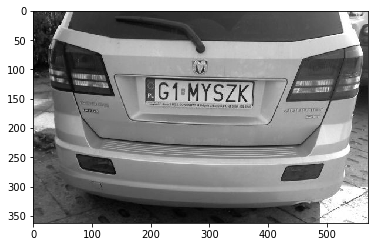

In [2]:
img_fn = '../data/examples/example1.jpg'
img = cv2.imread(img_fn, cv2.IMREAD_GRAYSCALE)
plt.imshow(img)

### Krok 2 - segmentacja tablicy
Samej segmentacji dokonujemy wykorzytując wytrenowany już klasyfikator kaskadowy cech haaro-podobnych.
Parametry modelu zapisane są w pliku xml.

Klasyfikator trenowany jest poprzez dostarczenie mu dużej liczby zdjęć, na których jest obiekt, który chcemy zidentyfikować oraz dużej liczby zdjęć, na których tego obiektu nie ma.

Istotą działania klasyfikatora Haar'a są tzw. cechy Haar'a. Cechy te zawierają informacje o zmianie wartości kontrastu pomiędzy prostokątnymi grupami pikseli. Zmiany te są wykorzystywane do określenia relatywnie jasnych i ciemnych obszarów. Dwie lub trzy sąsiadujące grupy o podobnej wariancji kontrastu tworzą cechę Haar'a. Cechy te mogą być łatwo skalowane tak, aby rozpoznawać obiekty o różnej wielkości.

<img src="http://docs.opencv.org/2.4/_images/haarfeatures.png">

<img src="http://docs.opencv.org/trunk/haar.png">


Budowa klasyfikatora odbywa się w oparciu o metodę Gentle Adaboost. 
Na obrazach zawierających obiekt należy wskazać ich położenie tak, aby algorytm miał informacje, które rejony są celem detekcji. 

Algorytm w działaniu jest algorytmem kaskadowym działającym na zasadzie przesuwnego okna.

Idea klasyfikatora kaskadowego polega na tym by nie aplikować na okno wszystkich cech, tylko by pogrupować je i aplikować iteracyjnie kolejnie grupy. Jeśli jedna z początkowych faz testu nie powiedzie się - nie sprawdza się już kolejnych cech. Jeśli okno pomyślnie przejdzie przez wszystkie fazy - jest to fragment szukanego obiektu.


###### Wracając do kodu:
- w ten sposób wykrywamy wszystkie tablice rejestracyjne na obrazie
- następnie wykorzytując znalezione współrzędne i wymiary wycinamy znalezione tablice
- wycięte tablice zapisuje do listy


In [3]:
haar_fn = 'haarcascade_russian_plate_number.xml'
haar = cv2.CascadeClassifier(haar_fn)
detected = haar.detectMultiScale(img)
plates = []
for x, y, w, h in detected:
    obj = img[y:y+h, x:x+w]
    plates.append(obj)

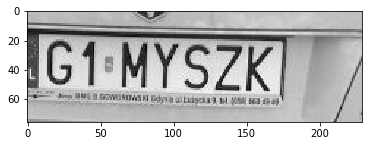

In [4]:
plt.imshow(plates[0])

### Krok 3 - segmentacja znaków

Do segmentacji znaków wykorzystana została metoda "thresholdingu". Testowaliśmy także działanie segmentacji dla metody "watershedingu" jednak nie zdała ona egzaminu w tym przypadku.

Metoda ta polega na zamianie każdego piksela obrazu pikselem czarnym jeśli intensywność obrazu: <img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/348b9cc1f8f5c6d18fa888bf7ebcca546f47c6f1"> jest mniejsza niż pewna stała T: <img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/04af1011ded288f782e2450dbec8a23c6a1811e8"> lub białym pikselem jeśli intensywność danego piksela jest większa niż zadana stała.

Wartość ta dobierana jest w sposób następujący:
- histogram obrazu wejściowego jest przetwarzany i wygładzany, aż do momentu gdy pozostaną dwa maksima
- gdy jest to już osiągnięte minimum jest szukaną wartością

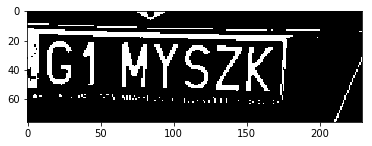

In [5]:
chars = plates[0] < filters.threshold_minimum(plates[0])

plt.imshow(chars)

### Krok 3.1 - znalezienie konturów

W celu znalezienie konturów wykorzystana została metoda z modułu "measures". 

Metoda ta wykorzystuje algorytm maszerujących kwadratów, krótko przedstawiony poniżej:

<img src="https://upload.wikimedia.org/wikipedia/commons/0/00/Marching_squares_algorithm.svg">

In [6]:
contours = measure.find_contours(chars, .1)

### Krok 3.2 - wycięcie znaków

Po znalezieniu konturów możemy zapisać współrzędne, oraz szerokość i wysokość wszystkich liter. Pomijamy te krótsze niż 15 pikseli.
Mając te dane wycinamy znaki z obrazu tablicy rejestracyjnej.



In [7]:
letters = []
for v in contours:
    xs, ys = zip(*v)
    x = int(min(xs))
    y = int(min(ys))
    w = int(max(xs) - x + 2)
    h = int(max(ys) - y + 2)
    if w < 15:
        continue
    letters.append((x,y,w,h))
    
letters = sorted(letters)
display(letters)

[(11, 0, 45, 183),
 (20, 13, 32, 19),
 (21, 37, 31, 10),
 (21, 64, 32, 19),
 (22, 86, 32, 18),
 (23, 107, 31, 19),
 (23, 128, 33, 20),
 (24, 149, 32, 20)]

### Krok 3.3 - filtracja wyciętych obrazów

Filtrujemy obrazy odrzucając te:
- dla których wartość lewego górengo piksela jest mniejsza bądź równa 127
- dla których rozmiar przkracza dozwoloną wielkość:
    - suma mediany rozmiarów wszystkich obrazów z medianą rozmiarów wszystkich obrazów podzieloną przez 8


In [8]:
letters_img = [plates[0][x:x+w, y:y+h] for x,y,w,h in letters]

letters_img = [i for i in letters_img if i[0,0] > 127]

In [9]:
sizes = [image.size for image in letters_img]
median = np.median(sizes)
allowed_size = median + median/8
display(median)

letters_img = [image for image in letters_img if image.size < allowed_size]
    
display([image.size for image in letters_img])

608.0

[608, 310, 608, 576, 589, 660, 640]

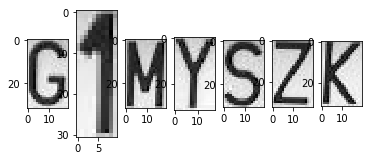

In [10]:
fig, axs = plt.subplots(1, len(letters_img))
for i, v in enumerate(letters_img):
    axs[i].imshow(v)

### Krok 4 - normalizacja znaków

W celu przekazania obrazów do przetwarzania przez sieć neuronową konieczna jest ich normalizacja do wymiarów 64x64.

In [11]:
size = 64

normalized_img = []
for i in letters_img:
    ratio = i.shape[0] / i.shape[1]
    img1 = transform.resize(i, [size, int(size / ratio)], mode='constant')
    width = img1.shape[1]
    missing = (size - width) // 2
    ones = np.ones([size, missing])
    img2 = np.append(ones, img1, 1)
    img3 = np.append(img2, ones, 1)
    if 2 * missing + width != size:
        one = np.ones([size, 1])
        img4 = np.append(img3, one, 1)
    else:
        img4 = img3
    normalized_img.append(img4 * 255)

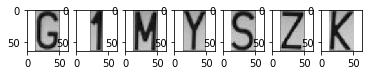

In [12]:
fig, axs = plt.subplots(1, len(normalized_img))
for i, v in enumerate(normalized_img):
    axs[i].imshow(v)

### Krok 5 - budowa sieci neuronowej

Nasza konwolucyjna sieć neuronowa składa się z 11 warstw, więc jest to już sieć głęboka.
Warstwa wejściowa przyjmuje tensory o rozmiarach [x, 64, 64, 1], gdzie x to liczba zdjęć na wejściu.
Pozwala to jednocześnie uczyć sieć na wielu przykładach.

Kolejne 3 pary warstw to warstwy, które występują w niemalże każdej sieci konwolucyjnej.
Składają się z warstw konwolucyjnych i warstw dokonujących max-pooling, tj. wybór wartości największej z kwadratu o pewnym rozmiarze (w naszym przypadku 2x2).

Następnie mamy warstwę w pełni połączoną.
Po niej następuje warstwa dropout, która odrzuca losowe neurony z pewnym prawdopodobieństwem w czasie uczenia, w celu uniknięcia przeuczenia.

Na koniec znajduje się kolejna warstwa w pełni połączona i warstwa wyjściowa, która zwraca wektor prawdopodobieństw o długości 36, gdyż mamy właśnie tyle etykiet.

#### Schemat ogólny sieci konwolucyjnej

<img src="https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-07-at-4-59-29-pm.png?w=748" />

In [13]:
net_input = input_data(shape=[None, 64, 64, 1])

conv1 = conv_2d(net_input, nb_filter=4, filter_size=5, strides=[1, 1, 1, 1], activation='relu')
max_pool1 = max_pool_2d(conv1, kernel_size=2)

conv2 = conv_2d(max_pool1, nb_filter=8, filter_size=5, strides=[1, 2, 2, 1], activation='relu')
max_pool2 = max_pool_2d(conv2, kernel_size=2)

conv3 = conv_2d(max_pool2, nb_filter=12, filter_size=4, strides=[1, 1, 1, 1], activation='relu')
max_pool3 = max_pool_2d(conv3, kernel_size=2)

fc1 = fully_connected(max_pool3, n_units=200, activation='relu')
drop1 = dropout(fc1, keep_prob=.5)

fc2 = fully_connected(drop1, n_units=36, activation='softmax')
net = regression(fc2)

### Krok 6 - model

Mając stworzoną sieć neuronową, wczytujemy do niej wytrenowane wcześniej wagi dla każdego neuronu, by móc przewidywać - z niemal 99% skutecznością - jakie znaki znajdują się na obrazkach.

In [14]:
model = DNN(network=net)
model.load(model_file='../data/model/model_weights')

INFO:tensorflow:Restoring parameters from /home/matbur/PycharmProjects/cypsio-pro/data/model/model_weights


### Krok 7 - predykcja

Ostatnim krokiem jest już właściwa predykcja znaków podanych na wejście sieci.
Odbywa się to poprzez wywołanie metody `predict` na obiekcie modelu.

In [15]:
labels = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')

predicted = []
for i in normalized_img:
    y = model.predict(i.reshape([1, 64, 64, 1]))
    y_pred = np.argmax(y[0])
    predicted.append(labels[y_pred])

In [16]:
display(predicted)

['G', '1', 'M', 'Y', 'S', 'Z', 'K']

### Źródła
- [Tutorial detekcja twarzy open_cv](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html)
- [SiW-Rozpoznawanie wzorców i twarzy](http://eia.pg.edu.pl/documents/184139/37451054/SiW-Rozpoznawanie%20wzorc%C3%B3w%20i%20twarzy.pdf)
- [Metoda maszerujących kwadratów](http://users.polytech.unice.fr/~lingrand/MarchingCubes/algo.html)
- [Maszerujące kwadraty wiki](https://en.wikipedia.org/wiki/Marching_squares)
- [Skimage.measure](http://scikit-image.org/docs/dev/api/skimage.measure.html)
- [Skimage tutorial segmentation](http://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html)
- [Dokumentacja tflearn](http://tflearn.org/)

### Bonus

Cały projekt udostępniamy jako paczkę pythonową. Ułatwia to uruchamianie naszego projektu.

Jedyne co należy zrobić, to wkleić poniższy snippet do terminala.
```
git clone https://github.com/matbur95/cypsio-pro --depth 1
cd cypsio-pro/falpr
pip install .

xdg-open ../data/examples/example1.jpg &
python -m falpr -i ../data/examples/example1.jpg```